<a href="https://colab.research.google.com/github/zodbot/llm_finetuning/blob/main/lora_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7f5db8f82ed0>)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M",
    models_dir="/content/drive/MyDrive/gpt2"
)

Mounted at /content/drive
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/checkpoint
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/encoder.json
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/hparams.json
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/vocab.bpe


In [3]:

import sys

!git clone https://github.com/zodbot/llm_finetuning.git

# Change into repo directory
%cd llm_finetuning

from src.model import GPTModel
from src.config import GPT_CONFIGS
from src.utils import load_weights_into_gpt

# Get configuration
config = GPT_CONFIGS["gpt2-small (124M)"]

# Set up model for classification
model = GPTModel(config)
load_weights_into_gpt(model, params)
model.eval()


Cloning into 'llm_finetuning'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 124 (delta 52), reused 72 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (124/124), 1.27 MiB | 33.38 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/llm_finetuning


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Li

In [4]:
import torch

torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [5]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00


In [6]:
# SST-2 (Stanford Sentiment Treebank) is a great dataset for binary sentiment classification
from datasets import load_dataset
ds = load_dataset('nyu-mll/glue', 'sst2', split='train')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [7]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.6 MB/s eta 0:00:00


In [8]:
# Convert to pandas DataFrame
import pandas as pd
import tiktoken

df = pd.DataFrame({
    'Label': ds['label'],
    'Text': ds['sentence']
})
tokenizer = tiktoken.get_encoding("gpt2")
print(len(df))
print(df["Label"].value_counts())

# Take random sample of 1000 rows
df_sample = df.sample(n=500, random_state=42)  # random_state for reproducibility

# Optional: Look at the distribution of labels to ensure it's balanced
print("Label distribution in sample:")
print(df_sample['Label'].value_counts())

def random_split(df, train_frac, validation_frac):
    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(df, 0.7, 0.1)

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

f = open("train.csv")
inputs = []
max_length = 0
for line in f.read():
  ids = tokenizer.encode(line)
  max_length = max(max_length, len(ids))
  inputs.append(ids)


for input in inputs:
  for _ in range(max_length - len(input)):
    input.append(5027)

67349
Label
1    37569
0    29780
Name: count, dtype: int64
Label distribution in sample:
Label
1    281
0    219
Name: count, dtype: int64


In [9]:
import torch
from torch.utils.data import Dataset
# it identifies the longest sequence in the training dataset, encodes the text messages,
# and ensures that all other sequences are padded with a padding token to match the length of the longest sequence.
class Sst2DataSet(Dataset):
  def __init__(self, csv_file, tokenizer, max_length=None,
                 pad_token_id=50256):
      self.data = pd.read_csv(csv_file)
      self.encoded_texts = [tokenizer.encode(data) for data in self.data["Text"]]
      if max_length is None:
          self.max_length = self._longest_length()
      else:
          self.max_length = max_length
      # Truncates sequences if they are longer than max_length
      self.encoded_texts = [
                  encoded_text[:self.max_length]
                  for encoded_text in self.encoded_texts
      ]
      # add padding
      self.encoded_texts = [
        encoded_text + [pad_token_id] *
        (self.max_length - len(encoded_text))
        for encoded_text in self.encoded_texts
      ]


  def __getitem__(self, index):
      encoded = self.encoded_texts[index]
      label = self.data.iloc[index]["Label"]
      return (
          torch.tensor(encoded, dtype=torch.long),
          torch.tensor(label, dtype=torch.long)
      )
  def __len__(self):
      return len(self.data)

  def _longest_length(self):
      max_length = 0
      for encoded_text in self.encoded_texts:
          encoded_length = len(encoded_text)
          if encoded_length > max_length:
              max_length = encoded_length
      return max_length


train_dataset = Sst2DataSet(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

val_dataset = Sst2DataSet(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = Sst2DataSet(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
print(train_dataset.max_length)

65


In [10]:
import torch


from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
print("# of batches: ", len(train_loader))
for train, target in train_loader:
  print(train.shape, target.shape)
  break

# of batches:  5893
torch.Size([8, 65]) torch.Size([8])


In [11]:
def calc_loss(data_loader, model, device, num_batches=None):
  if len(data_loader) == 0:
    return float("nan")

  if num_batches is None:
    num_batches = len(data_loader)

  model.eval()

  all_loss = 0

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      input_batch = input_batch.to(device)
      target_batch = target_batch.to(device)

      with torch.no_grad():
        predicted = model(input_batch)
      # we only care about the last token
      predicted = predicted[:, -1, :]
      loss = torch.nn.functional.cross_entropy(predicted, target_batch)
      all_loss += loss.item()
    else:
      break

  return all_loss / num_batches

In [12]:
def calc_accuracy(data_loader, model, device, num_batches=None):
    """
    Calculate model accuracy on a dataset.

    Args:
        data_loader: DataLoader containing the evaluation data
        model: The model to evaluate
        device: Device to run evaluation on ('cuda' or 'cpu')
        num_batches: Maximum number of batches to evaluate (None for all)

    Returns:
        float: Accuracy as a percentage (0-1)
    """
    if len(data_loader) == 0:
        return float("nan")

    if num_batches is None:
        num_batches = len(data_loader)

    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i >= num_batches:
                break

            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            # Forward pass
            outputs = model(input_batch)

            # Get last token predictions if this is a sequence model
            if len(outputs.shape) > 2:
                outputs = outputs[:, -1, :]

            _, predicted = torch.max(outputs, 1)

            # Calculate accuracy
            total += target_batch.size(0)
            correct += (predicted == target_batch).sum().item()

    accuracy = correct / total if total > 0 else 0
    return accuracy

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)[:, -1, :]
  loss = torch.nn.functional.cross_entropy(logits, target_batch)
  return loss

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
      train_loss = calc_loss(
            train_loader, model, device, num_batches=eval_iter
        )
      val_loss = calc_loss(
            val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [14]:
torch.manual_seed(123)
train_accuracy = calc_accuracy(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy(
    test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 55.00%
Validation accuracy: 62.50%
Test accuracy: 61.25%


**Parameter-efficient fine-tuning with LoRA**

In LoRA, the typical goal is to substitute existing Linear layers, allowing weight updates to be applied directly to the pre-existing pretrained weights

alpha: functions as a scaling factor for the output from the low-rank adaptation. It primarily dictates the degree to which the output from the adapted layer can affect the original layer’s output.

LoRA matrices A and B:  approximate the weight update matrix ΔW

In [15]:
import math
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

In [16]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )
    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [17]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
# Replaces the Linear layer with LinearWithLoRA
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            replace_linear_with_lora(module, rank, alpha)

In [18]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

# freeze the model
for param in model.parameters():
    param.requires_grad = False

# replace the linear layers with lora
replace_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)




Total trainable parameters before: 124,441,346
Total trainable LoRA parameters: 2,666,528
GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequenti

In [19]:
# Test the LoRA layer
lora = LoRALayer(10, 5, 2, 1.0)
test_input = torch.randn(3, 10)
output = lora(test_input)
print(f"Input shape: {test_input.shape}, Output shape: {output.shape}")

Input shape: torch.Size([3, 10]), Output shape: torch.Size([3, 5])


In [20]:
torch.manual_seed(123)
train_accuracy = calc_accuracy(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy(
    test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 55.00%
Validation accuracy: 62.50%
Test accuracy: 61.25%


In [21]:
def train_classifier(model, data_loader, val_loader, optimizer, device,
               epoch_num, eval_freq, eval_iter):
  model.train()
  examples_seen = 0
  steps = -1
  train_losses, val_losses, train_accs, val_accs = [], [], [], []

  for epoch in range(epoch_num):
    model.train()
    for i, (input_batch, target_batch) in enumerate(data_loader):
      input_batch = input_batch.to(device)
      target_batch = target_batch.to(device)
      # reset optimizer
      optimizer.zero_grad()

      loss = calc_loss_batch(input_batch, target_batch, model, device)

      # cal loss gradient
      loss.backward()

      # update weight
      optimizer.step()
      # we care about number of smples not tokens here
      examples_seen += input_batch.shape[0]
      steps += 1

      if steps % eval_freq == 0:
          train_loss, val_loss = evaluate_model(
            model, data_loader, val_loader, device, eval_iter)
          train_losses.append(train_loss)
          val_losses.append(val_loss)
          print(f"Ep {epoch+1} (Step {steps:06d}): "
                f"Train loss {train_loss:.3f}, "
                f"Val loss {val_loss:.3f}")

    train_accuracy = calc_accuracy(
      data_loader, model, device, num_batches=eval_iter
    )
    val_accuracy = calc_accuracy(
      val_loader, model, device, num_batches=eval_iter
    )
    print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)

  return train_losses, val_losses, train_accs, val_accs, examples_seen

In [22]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier(
        model, train_loader, val_loader, optimizer, device,
        epoch_num=num_epochs, eval_freq=2000, eval_iter=5)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.755, Val loss 2.275
Ep 1 (Step 000100): Train loss 0.686, Val loss 0.691
Ep 1 (Step 000200): Train loss 0.689, Val loss 0.691
Ep 1 (Step 000300): Train loss 0.694, Val loss 0.696
Ep 1 (Step 000400): Train loss 0.695, Val loss 0.694
Ep 1 (Step 000500): Train loss 0.650, Val loss 0.674
Ep 1 (Step 000600): Train loss 0.785, Val loss 0.784
Ep 1 (Step 000700): Train loss 0.715, Val loss 0.762
Ep 1 (Step 000800): Train loss 0.771, Val loss 0.735
Ep 1 (Step 000900): Train loss 0.692, Val loss 0.695
Ep 1 (Step 001000): Train loss 0.688, Val loss 0.689
Ep 1 (Step 001100): Train loss 0.680, Val loss 0.687
Ep 1 (Step 001200): Train loss 0.720, Val loss 0.709
Ep 1 (Step 001300): Train loss 0.677, Val loss 0.692
Ep 1 (Step 001400): Train loss 0.697, Val loss 0.686
Ep 1 (Step 001500): Train loss 0.673, Val loss 0.678
Ep 1 (Step 001600): Train loss 0.663, Val loss 0.684
Ep 1 (Step 001700): Train loss 0.687, Val loss 0.692
Ep 1 (Step 001800): Train loss 0.678, Val loss

In [23]:
# lora_config = LoraConfig(
#     r=16,                     # rank
#     lora_alpha=32,            # scaling factor
#     target_modules=["q_proj", "v_proj"],  # modules to apply LoRA to
#     lora_dropout=0.05,
#     bias="none"
# )

# Save just the LoRA weights
torch.save({
    'lora_state_dict': {k: v for k, v in model.state_dict().items() if 'lora' in k},
    'config': {'r': 6, 'alpha':6},  # Save rank, alpha, etc.
}, 'ss2_lora_adapter.pt')

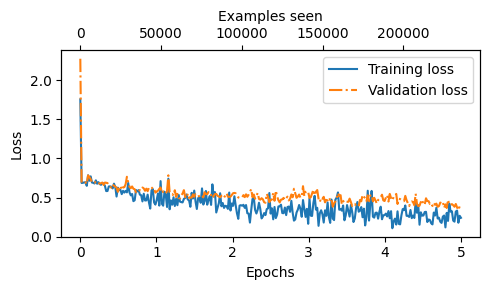

In [24]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
  label="loss"):
  fig, ax1 = plt.subplots(figsize=(5, 3))

  ax1.plot(epochs_seen, train_values, label=f"Training {label}")
  ax1.plot(
  epochs_seen, val_values, linestyle="-.",
      label=f"Validation {label}"
  )
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel(label.capitalize())
  ax1.legend()

  ax2 = ax1.twiny()
  ax2.plot(examples_seen, train_values, alpha=0)
  ax2.set_xlabel("Examples seen")

  fig.tight_layout()
  plt.savefig(f"{label}-plot.pdf")
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [25]:
# # Load base model
# base_model = load_base_model()
# # Apply LoRA architecture
# lora_model = add_lora_to_model(base_model, config)
# # Load just the LoRA weights
# checkpoint = torch.load('my_task_lora_adapter.pt')
# lora_model.load_state_dict(checkpoint['lora_state_dict'], strict=False)

In [26]:
torch.manual_seed(123)
train_accuracy = calc_accuracy(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy(
    test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 87.50%
Validation accuracy: 83.75%
Test accuracy: 91.25%
